In [41]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import datetime
import statistics

In [2]:
# load data as dataframe
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"
count = 0
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    # import data
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [4]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

# 2016-2019 data
df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 25000)& (df1['usd_pledged'] > 2500)]
df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')


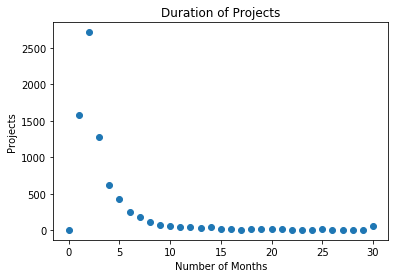

In [45]:
df2 = df1.copy()

df2['duration'] = (df2['deadline'] - df2['created_at']) / np.timedelta64(1,'M')
new_dict = {}

for i in range(31):
    new_dict[i] = 0
for j in df2['duration']:
    if round(j) < 30:
        new_dict[round(j)] += 1
    else:
        new_dict[30] += 1

plt.scatter(new_dict.keys(),new_dict.values())
plt.xlabel('Number of Months')
plt.ylabel('Projects')
plt.title('Duration of Projects')
plt.show()

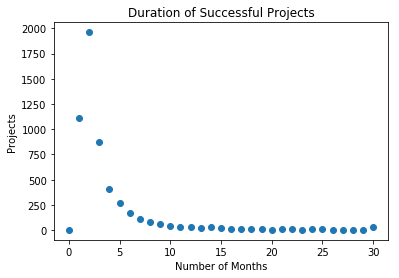

In [44]:
df2_success = df1_success.copy()

df2_success['duration'] = (df2_success['deadline'] - df2_success['created_at']) / np.timedelta64(1,'M')
new_dict_success = {}

for i in range(31):
    new_dict_success[i] = 0
for j in df2_success['duration']:
    if round(j) < 30:
        new_dict_success[round(j)] += 1
    else:
        new_dict_success[30] += 1

plt.scatter(new_dict_success.keys(),new_dict_success.values())
plt.xlabel('Number of Months')
plt.ylabel('Projects')
plt.title('Duration of Successful Projects')
plt.show()

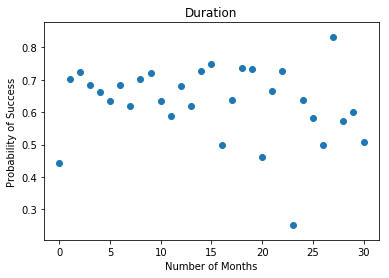

In [43]:
new_dict_success_rate = {}

for i in new_dict.keys():
    new_dict_success_rate[i] = new_dict_success[i] / new_dict[i]
    
plt.scatter(new_dict_success_rate.keys(),new_dict_success_rate.values())
plt.xlabel('Number of Months')
plt.ylabel('Probability of Success')
plt.title('Duration')
plt.show()